In [1]:
import uproot
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve,auc
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense,Dropout
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
import time
import joblib
import warnings
warnings.filterwarnings('ignore')

pjoin = os.path.join

# User inputs

In [2]:
model='VLLtau'
mass=400
background="WJetsInclusive"

In [3]:
inputdir="inputData/"

file_bkg = "VLLRun2_MVATrainingTree_WJetsInclusive_sample.root"
file_sig = f"VLLRun2_MVATrainingTree_{model}_M{mass}_sample.root"

file_sig =pjoin(inputdir,file_sig)
file_bkg =pjoin(inputdir,file_bkg)

df_sig = uproot.open(file_sig+':Events').arrays(library='pd')
df_bkg = uproot.open(file_bkg+':Events').arrays(library='pd')

print('No of signal events before any selection = ',df_sig.shape[0])
print('No of bkg events before any selection = ',df_bkg.shape[0])

print('No of total features = ',df_sig.shape[1])

No of signal events before any selection =  60675
No of bkg events before any selection =  564173
No of total features =  76


In [4]:
## Apply Signal Region Selection criteria for the 1L2J VLL analysis

selection= "lep0_iso<0.15 & dijet_mass>50 & dijet_mass<110 & deltaR_jet01<2.6"# & event_ST>250"

df_sig_sel = df_sig.query(selection)
df_bkg_sel = df_bkg.query(selection)

print('before selection...')
print('-------------------------------')
print('No of signal events before any selection = ',df_sig.shape[0])
print('No of bkg events before any selection = ',df_bkg.shape[0])
print('\nafter selection...')
print('-------------------------------')
print('No of signal events after selection = ',df_sig_sel.shape[0])
print('No of bkg events after selection = ' ,df_bkg_sel.shape[0])

print('\nNo of total features = ',df_sig_sel.shape[1])

before selection...
-------------------------------
No of signal events before any selection =  60675
No of bkg events before any selection =  564173

after selection...
-------------------------------
No of signal events after selection =  48231
No of bkg events after selection =  338686

No of total features =  76


### Input variables

In [5]:

def createNewColumn(df_):
    df = df_.copy()
    mybin=[0,0.2,0.5,0.8,1.01]
    mybinlabel=[1,2,3,4]
    df.loc[:,'QGjet0cat']=pd.cut(df['deepjetQG_jet0'],bins=mybin,labels=mybinlabel,include_lowest=True)
    df.loc[:,'QGjet1cat']=pd.cut(df['deepjetQG_jet1'],bins=mybin,labels=mybinlabel,include_lowest=True)
    df.loc[:,'avgQGcat'] =pd.cut(df['event_avgQGscore'],bins=mybin,labels=mybinlabel,include_lowest=True)

    return df



In [6]:
df_sig_sel=createNewColumn(df_sig_sel)
df_bkg_sel=createNewColumn(df_bkg_sel)

In [7]:
feature_list=[
'lep0_pt','lep0_eta','lep0_mt','jet0_pt','jet0_eta','jet0_mt',
'jet1_pt','jet1_eta', 'jet1_mt','dijet_pt','dijet_mt',
'deltaR_jet01','deltaPhi_metjet0', 'deltaPhi_metjet1', 'deltaPhi_metlep0',
'deltaPhi_jet0lep0', 'deltaPhi_jet1lep0',
'deltaPhi_dijetlep0','deltaPhi_metdijet',
'event_MET', 'event_HT', 'n_Jet',
'deepjetQG_jet0', 'deepjetQG_jet1','event_avgQGscore'
]
feature_list.remove('lep0_mt')
feature_list.remove('deepjetQG_jet0')
feature_list.remove('deepjetQG_jet1')
feature_list.remove('event_avgQGscore')
feature_list.append('QGjet0cat')
feature_list.append('QGjet1cat')
feature_list.append('avgQGcat')

### create signal and background dataframe

In [8]:
n_bkg_event=df_sig_sel.shape[0]+100000 

df_sig_sel_nn = df_sig_sel[feature_list]
df_bkg_sel_nn = df_bkg_sel[feature_list].sample(n_bkg_event)

df_sig_sel_nn.loc[:,'label']=1
df_bkg_sel_nn.loc[:,'label']=0

data = pd.concat([df_sig_sel_nn,df_bkg_sel_nn])

## proceed to training
- split the whole dataset into training(80%) and testing(20%)
- normalize the input variables to have similarish ranges
- built model architecture
- training

In [9]:
np.random.seed(31415)

X,y = data.values[:,:-1],data.values[:,-1]
X_train, X_test, y_train, y_test= train_test_split(X,y,train_size=0.8)

##Normalize the input
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"train stat: sig= {X_train[y_train==1].shape[0]} | bkg={X_train[y_train==0].shape[0]}")
print(f"test stat:  sig= {X_test[y_test==1].shape[0]} | bkg={X_test[y_test==0].shape[0]}")

train stat: sig= 38608 | bkg=118561
test stat:  sig= 9623 | bkg=29670


### model architecture

In [10]:
modelfiledir='modeldata/'
modelname=f'{background}vsVLLtauM{mass}'

epoch = 25
batchsize=1600

In [11]:
#define callbacks. Here the model with highest accuracy will be saved at end...
cb = [ModelCheckpoint(filepath=f"{modelfiledir}/best_model_{modelname}.h5",monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')]
"""
Model Architecture
"""
model = Sequential()
model.add(Dense(128, activation='relu', kernel_initializer='he_normal', input_shape=(len(feature_list),)))
model.add(Dropout(0.3))
#model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(100, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(8, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1, activation='sigmoid'))

2024-12-31 19:12:00.190507: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-12-31 19:12:00.191250: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-31 19:12:00.197144: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [12]:
#compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train,y_train, epochs=epoch, batch_size=batchsize,validation_data=(X_test, y_test), verbose=1,callbacks=cb)
model.summary()
model.save(f'{modelfiledir}/{modelname}.h5')
joblib.dump(scaler,f'{modelfiledir}/scaler_{modelname}.save')

2024-12-31 19:12:00.388900: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-12-31 19:12:00.413546: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2299965000 Hz


Epoch 1/25
99/99 [==============================] - 11s 90ms/step - loss: 0.3736 - accuracy: 0.8535 - val_loss: 0.1812 - val_accuracy: 0.9295

Epoch 00001: val_accuracy improved from -inf to 0.92945, saving model to modeldata/best_model_WJetsInclusivevsVLLtauM400.h5
Epoch 2/25
99/99 [==============================] - 8s 79ms/step - loss: 0.2011 - accuracy: 0.9225 - val_loss: 0.1691 - val_accuracy: 0.9349

Epoch 00002: val_accuracy improved from 0.92945 to 0.93490, saving model to modeldata/best_model_WJetsInclusivevsVLLtauM400.h5
Epoch 3/25
99/99 [==============================] - 8s 80ms/step - loss: 0.1865 - accuracy: 0.9302 - val_loss: 0.1657 - val_accuracy: 0.9366

Epoch 00003: val_accuracy improved from 0.93490 to 0.93663, saving model to modeldata/best_model_WJetsInclusivevsVLLtauM400.h5
Epoch 4/25
99/99 [==============================] - 7s 72ms/step - loss: 0.1802 - accuracy: 0.9317 - val_loss: 0.1636 - val_accuracy: 0.9376

Epoch 00004: val_accuracy improved from 0.93663 to 0.

['modeldata//scaler_WJetsInclusivevsVLLtauM400.save']

### Accuracy and loss plots

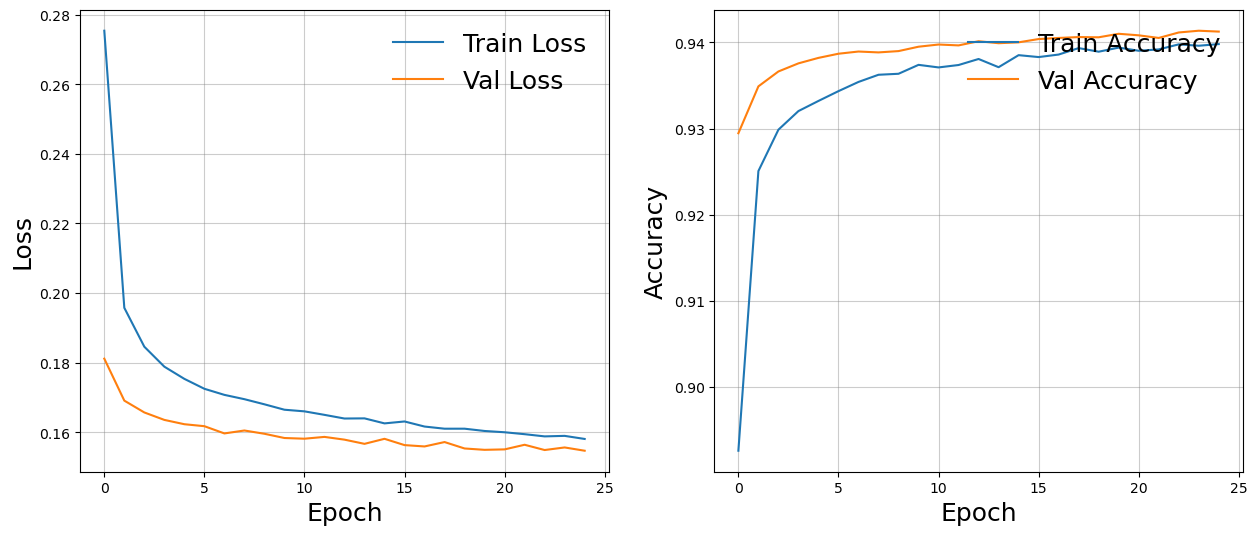

In [13]:
fig,ax = plt.subplots(1,2,figsize=(15,6))
ax =ax.flatten()

ax[0].plot(history.history['loss'], label='Train Loss')
ax[0].plot(history.history['val_loss'], label = 'Val Loss')
ax[0].set_xlabel('Epoch',fontsize=18)
ax[0].set_ylabel('Loss',fontsize=18)
#ax[0].set_ylim([0.001, 10])
#ax[0].set_yscale('log')
ax[0].grid('--',c='gray',alpha=0.4)
ax[0].legend(loc='upper right',fontsize=18,frameon=False)

#Accuracy
ax[1].plot(history.history['accuracy'], label='Train Accuracy')
ax[1].plot(history.history['val_accuracy'], label = 'Val Accuracy')
ax[1].set_xlabel('Epoch',fontsize=18)
ax[1].set_ylabel('Accuracy',fontsize=18)
#ax[1].set_ylim([0.70,0.75])
#ax[0].set_yscale('log')
ax[1].grid('--',c='gray',alpha=0.4)
ax[1].legend(loc='upper right',fontsize=18,frameon=False)
#fig.savefig(f'{plotdir}/{modelname}_training.png',facecolor='white',dpi=200)
#fig.savefig(pp,format='pdf')

### DNN score

In [14]:
from extra_functions import compare_train_test

y_pred_test = model.predict(X_test,batch_size=100000).ravel()
y_pred_train = model.predict(X_train,batch_size=10000).ravel()


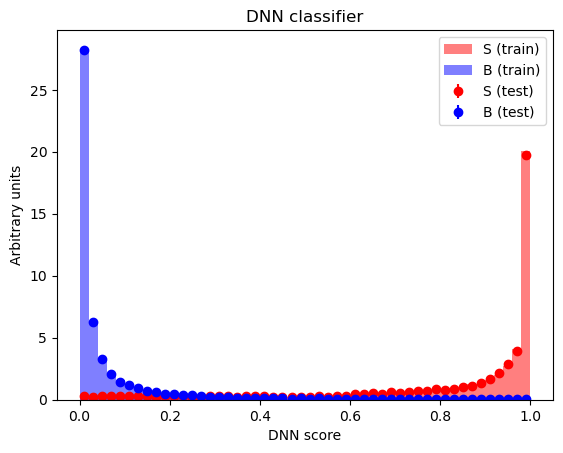

In [15]:
compare_train_test(
    y_pred_train,
    y_train,
    y_pred_test,
    y_test,
    bins=50,
    xlabel="DNN score",
    title='DNN classifier',
    log=False
)


### ROC curve

In [16]:
fpr, tpr, _ = roc_curve(y_test,y_pred_test)
auc_score = auc(fpr,tpr)
fpr1, tpr1, _ = roc_curve(y_train,y_pred_train)
auc_score1 = auc(fpr1,tpr1)

(0.0, 1.0)

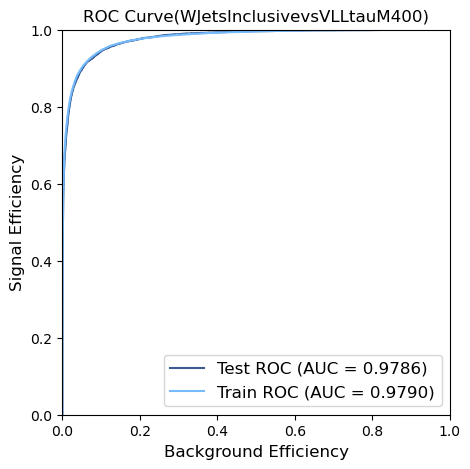

In [17]:
#ROC CURVE
plt.figure(figsize=(5,5))
plt.plot(fpr,tpr,color='xkcd:denim blue', label='Test ROC (AUC = %0.4f)' % auc_score)
plt.plot(fpr1,tpr1,color='xkcd:sky blue', label='Train ROC (AUC = %0.4f)' % auc_score1)
plt.legend(loc='lower right',fontsize=12)
plt.title(f'ROC Curve({modelname})',fontsize=12)
plt.xlabel('Background Efficiency',fontsize=12)
plt.ylabel('Signal Efficiency',fontsize=12)
plt.xlim(0.,1.)
plt.ylim(0.,1.)

In [18]:
os.listdir('modeldata/')

['best_model_WJetsInclusivevsVLLtauM400.h5',
 'scaler_WJetsInclusivevsVLLtauM400.save',
 'WJetsInclusivevsVLLtauM400.h5']